In [4]:
# from unet_model import *
import tensorflow as tf
from tensorflow import keras
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
# from keras.models import Model
# from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from datetime import datetime
import glob
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import numpy as np
import os
# import pandas as pd
# from PIL import Image
# import random
# import shutil

from unet_model import *
from data_prep import *

# from numba import cuda

# %load_ext tensorboard

tf.__version__

'2.3.0'

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_logical_devices('GPU')
# tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Model

## Load Model

In [8]:
model_name = "20200831-032132_lr001/"
model = keras.models.load_model("saved_models/"+model_name)

## Declare, Compile, and Train UNet Model

In [3]:
# To train only one model at a time. To train multiple in a row, run train_mult_models script

learning_rate = 0.001
print("Training with learning rate: " + str(learning_rate))

train_name = datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr" + str(learning_rate).split('.')[1]
logdir = "logs/" + train_name
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = unet_model((512,512,1))
# model.summary()

opt = keras.optimizers.Adam(learning_rate=learning_rate) # default is 0.001
model.compile(optimizer = opt, loss="binary_crossentropy", metrics=["accuracy"])

# create_generators
seed = 1
batchsize = 2

train_generator, val_generator = create_generators(seed=seed, batchsize=batchsize)
# train_generator, val_generator = create_generators("tranformed_val", seed=seed, batchsize=batchsize)

epochs = 50

# history = model.fit(x=X_train, y=Y_train, epochs=30, batch_size=1)

history = model.fit(
    train_generator,
    steps_per_epoch=24/batchsize, # TODO: fix this #TODO: check that mult by 10 reduces number of epochs to get to same thing 
    validation_data=val_generator,
    validation_steps=6/batchsize, # TODO: fix this
    epochs=epochs,
    verbose=1
    callbacks=[tensorboard_callback]
)

os.makedirs("saved_models/"+train_name+"/")
model.save("saved_models/"+train_name+"/")

# tf.keras.backend.clear_session()
# tf.compat.v1.reset_default_graph()

# Model Analysis

## Import all training image

In [159]:
# # img_path = "../unet/data/membrane/train/image/0.png"

# # img = image.load_img(img_path)
# # imshow(img)

# # x = image.img_to_array(img)
# # print(x[0,0])
# # print(x.shape)
# # print(x[0].shape)
# # print(x[0][9])
# # # history = model.fit()

# # load in images

# assert (len(glob.glob("../unet/data/membrane/train/image/*.png")) == len(glob.glob("../unet/data/membrane/train/label/*.png")))
# X_train_orig = []
# Y_train_orig = []
# for i in range(len(glob.glob("../unet/data/membrane/train/image/*.png"))):
#     img_path = "../unet/data/membrane/train/image/{}.png".format(i)
#     img = image.load_img(img_path)
#     x = image.img_to_array(img)[:,:,0] # since grayscale, only care about one of 3 channels
#     x = np.expand_dims(x, axis=-1)
#     X_train_orig.append(x)
    
#     img_path = "../unet/data/membrane/train/label/{}.png".format(i)
#     img = image.load_img(img_path)
#     y = image.img_to_array(img)[:,:,0]
#     y = np.expand_dims(y, axis=-1)
#     Y_train_orig.append(y)
    
# X_train_orig = np.array(X_train_orig)
# print (X_train_orig.shape)
# Y_train_orig = np.array(Y_train_orig)
# print(Y_train_orig.shape)

# X_train = X_train_orig / 255
# Y_train = Y_train_orig / 255
# print(Y_train_orig[0,0,0,0])
# print(Y_train[0,0,0,0])

# X_test_orig = []

# for i in range(len(glob.glob("../unet/data/membrane/test/*predict.png"))): # TODO: find better way to iterate over
#     img_path = "../unet/data/membrane/test/{}.png".format(i)
#     img = image.load_img(img_path)
#     x = image.img_to_array(img)[:,:,0]
#     x = np.expand_dims(x, axis=-1)
#     X_test_orig.append(x)
    
# X_test_orig = np.array(X_test_orig)
# print(X_test_orig.shape)

# X_test = X_test_orig / 255


# print (X_train.shape)
# print(Y_train.shape)

# Visualize Predictions

### Training Set

In [130]:
train_img_to_compare = 0 # Be careful and make sure you know which images are in temp_train_val_split

train_img = image.load_img("data/temp_train_val_split/train_image/{}.png".format(train_img_to_compare))
true_train_mask = image.load_img("data/temp_train_val_split/train_mask/{}.png".format(train_img_to_compare))

pred_train_mask = model.predict(np.expand_dims(image.img_to_array(train_img)[:,:,0:1]/255.0, axis=0))
pred_train_mask = (pred_train_mask[0,:,:,0] > 0.5).astype(int)

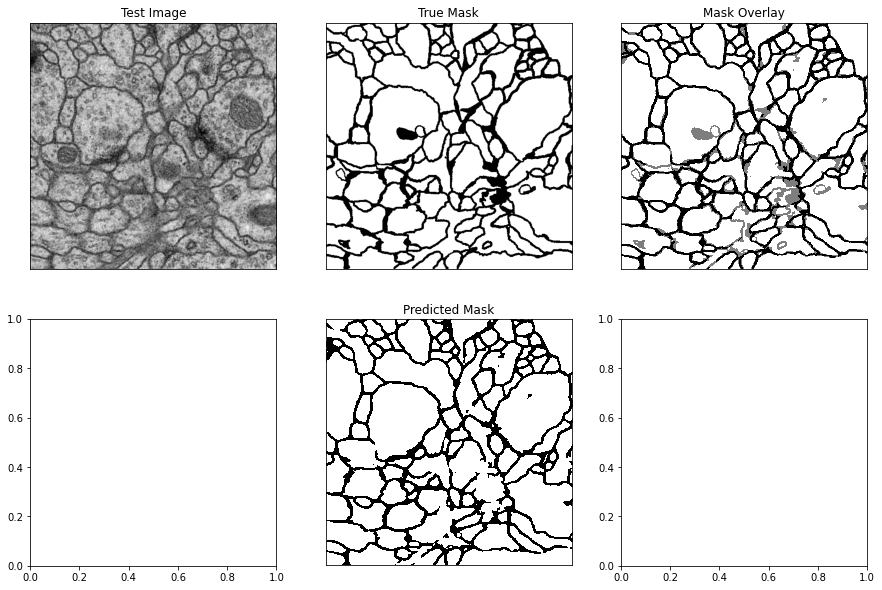

In [158]:

fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2,3)
fig.set_size_inches(15, 10)

ax11.imshow(train_img, cmap="ocean")
ax11.set_title("Test Image")
ax11.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

ax12.imshow(true_train_mask)
ax12.set_title("True Mask")
ax12.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

ax22.imshow(pred_train_mask, cmap="gray", interpolation="none") # need to only get one channel, otherwise cmap is ignored
ax22.set_title("Predicted Mask")
ax22.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

ax13.imshow(image.img_to_array(true_train_mask)[:,:,0]/255.0, cmap="gray", interpolation="none")
ax13.imshow(pred_train_mask, cmap="bone", alpha=0.5, interpolation="none")
ax13.set_title("Mask Overlay")
ax13.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

### Test Set

Save predicted segmentations

In [178]:
save_to = "data/test_set/predictions/"+model_name
os.makedirs(save_to)

for f in os.listdir("data/test_set/images/"):
    img_path = "data/test_set/images/" + f
    img = image.load_img(img_path)
    x = image.img_to_array(img)[:,:,0:1]
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    
    predicted = model.predict(x)    
    rescaled = ((predicted[0,:,:,0]>0.5) * 255).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save(save_to+f)

Look at predictions

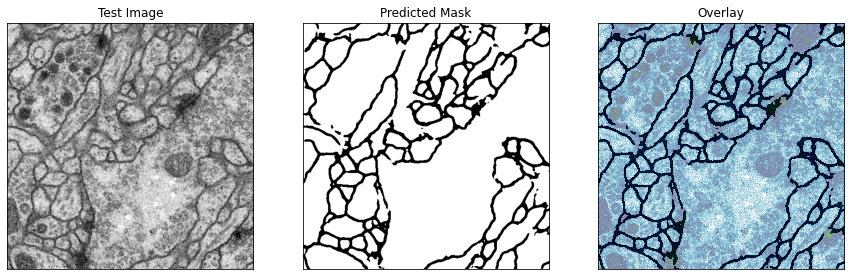

In [111]:
img_to_compare = 0
test_img = image.load_img("data/test_set/images/{}.png".format(img_to_compare))
img_mask = image.load_img("data/test_set/predictions/20200831-032132_lr001/{}.png".format(img_to_compare))

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(15, 10)

ax1.imshow(test_img, cmap="ocean")
ax1.set_title("Test Image")
ax1.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

ax2.imshow(img_mask)
ax2.set_title("Predicted Mask")
ax2.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

ax3.imshow(image.img_to_array(test_img)[:,:,0]/255.0, cmap="ocean", interpolation="none") # need to only get one channel, otherwise cmap is ignored
ax3.imshow(image.img_to_array(img_mask)[:,:,0]/255.0, cmap="gray", alpha=0.5, interpolation="none")
ax3.set_title("Overlay")
ax3.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

In [93]:
# imshow([[0,1],[1,0]], cmap="gray", vmin=0, vmax=1)

## Analyze Loss and Accuracy

This only works when you run a model in this notebook.<br>
Doesn't make sense to run this sense one can use TensorBoard (see logs directory)

In [179]:
# print(history.history.keys())
# # print(history.history['loss'])
# loss = history.history['loss']
# acc = history.history['accuracy']

# val_loss = history.history['val_loss']
# val_acc = history.history['val_accuracy']

In [181]:
# fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2)

# fig.set_size_inches(15, 10)

# ax11.plot(range(1,epochs+1), loss)
# ax11.plot(range(1,epochs+1), val_loss)
# ax11.set_title('Loss')
# ax11.set_xlabel("Epoch")
# ax11.set_ylabel("Loss");
# ax11.set_ylim(0,1)
# ax11.legend(['acc', 'val_acc'])

# ax12.plot(range(1,epochs+1), acc)
# ax12.plot(range(1,epochs+1), val_acc)
# ax12.set_title('Accuracy')
# ax12.set_xlabel("Epoch")
# ax12.set_ylabel("Percentage");
# ax12.set_ylim(0,1);
# ax12.legend(['acc', 'val_acc'])

# ax21.plot(range(1,epochs+1), loss)
# ax21.plot(range(1,epochs+1), val_loss)
# ax21.set_title('Loss')
# ax21.set_xlabel("Epoch")
# ax21.set_ylabel("Loss");
# ax21.legend(['loss', 'val_loss'])

# ax22.plot(range(1,epochs+1), acc)
# ax22.plot(range(1,epochs+1), val_acc)
# ax22.set_title('Accuracy')
# ax22.set_xlabel("Epoch")
# ax22.set_ylabel("Percentage")
# ax22.legend(['acc', 'val_acc'])